In [ ]:
## YENI VERSIYON

import yfinance as yf

symbols = ['AAPL', 'VOO', 'DIA']
data_dict = {}

for symbol in symbols:
    data = yf.Ticker(symbol).history(period="1mo")

    if data.empty:
        print(f"{symbol} data is empty. Skipping.")
        continue

    data['Symbol'] = symbol
    data_dict[symbol] = data

    print(f"\n{symbol} Closing Prices:")
    print(data['Close'])



AAPL Closing Prices:
Date
2025-07-07 00:00:00-04:00    209.949997
2025-07-08 00:00:00-04:00    210.009995
2025-07-09 00:00:00-04:00    211.139999
2025-07-10 00:00:00-04:00    212.410004
2025-07-11 00:00:00-04:00    211.160004
2025-07-14 00:00:00-04:00    208.619995
2025-07-15 00:00:00-04:00    209.110001
2025-07-16 00:00:00-04:00    210.160004
2025-07-17 00:00:00-04:00    210.020004
2025-07-18 00:00:00-04:00    211.179993
2025-07-21 00:00:00-04:00    212.479996
2025-07-22 00:00:00-04:00    214.399994
2025-07-23 00:00:00-04:00    214.149994
2025-07-24 00:00:00-04:00    213.759995
2025-07-25 00:00:00-04:00    213.880005
2025-07-28 00:00:00-04:00    214.050003
2025-07-29 00:00:00-04:00    211.270004
2025-07-30 00:00:00-04:00    209.050003
2025-07-31 00:00:00-04:00    207.570007
2025-08-01 00:00:00-04:00    202.380005
2025-08-04 00:00:00-04:00    203.350006
2025-08-05 00:00:00-04:00    202.919998
Name: Close, dtype: float64

VOO Closing Prices:
Date
2025-07-07 00:00:00-04:00    570.609985

Downloads the price data and calculates technical indicators (MA, Bollinger Bands, Z-Score, RSI).

Fills missing values.

Creates an Anomaly label based on Z-Score (>2 or <-2).

Trains an XGBoost model using selected features.

Makes predictions and prints classification results.

Generates a Signal column:

'SELL' when the model predicts an anomaly,

'BUY' on the following day,

otherwise 'HOLD'.

In [ ]:
#Libraries for ML

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# --- RSI function ---
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data = yf.Ticker(...).history(...) → downloads 20-year daily price data for each stock

data['MA_5'], data['MA_10'] → calculates 5-day and 10-day moving averages

data['STD_10'] → computes 10-day rolling standard deviation

Upper_Band / Lower_Band → creates Bollinger Bands using MA ± 2×STD

data_dict[symbol] = data → stores processed data in a dictionary

Plotly figure → visualises Close price, MAs, and Bollinger Bands for each stock




In [ ]:
## YENI VERSIYON

import yfinance as yf
import plotly.graph_objects as go

symbols = ['AAPL', 'VOO', 'DIA']
data_dict = {}

for symbol in symbols:
    data = yf.Ticker(symbol).history(period="20y", interval="1d")
    if data.empty:
        continue
    data['MA_5'] = data['Close'].rolling(window=5).mean()
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['STD_10'] = data['Close'].rolling(window=10).std()
    data['Upper_Band'] = data['MA_10'] + 2 * data['STD_10']
    data['Lower_Band'] = data['MA_10'] - 2 * data['STD_10']
    data_dict[symbol] = data

    # Chart for each symbol
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data.index, y=data['Close'], name=f'{symbol} Close'))
    fig.add_trace(go.Scatter(x=data.index, y=data['MA_5'], name='5-Day MA', line=dict(dash='dash')))
    fig.add_trace(go.Scatter(x=data.index, y=data['MA_10'], name='10-Day MA', line=dict(dash='dot')))
    fig.add_trace(go.Scatter(x=data.index, y=data['Upper_Band'], name='Upper Bollinger Band', line=dict(dash='dot')))
    fig.add_trace(go.Scatter(x=data.index, y=data['Lower_Band'], name='Lower Bollinger Band', line=dict(dash='dot')))

    fig.update_layout(title=f'{symbol}: Price with MA and Bollinger Bands',
                      xaxis_title='Date',
                      yaxis_title='Price (USD)',
                      hovermode='x unified')
    fig.show()


* **`df = data_dict[symbol]`** → loads the dataframe for the current stock
* **`df.fillna(...)`** → replaces any missing values using a 5-day rolling average
* **`data_dict[symbol] = df`** → saves the cleaned dataframe back into the dictionary


In [ ]:


for symbol in symbols:
    df = data_dict[symbol]
    df = df.fillna(df.rolling(window=5, min_periods=1).mean())
    data_dict[symbol] = df


* **`df['Z_Score'] = ...`** → calculates how far the current price is from the 10-day moving average (standardised).
* **`df['RSI'] = compute_rsi(...)`** → computes the 14-day Relative Strength Index to capture price momentum.
* **`data_dict[symbol] = df`** → saves the updated dataframe back to the dictionary.


In [ ]:


for symbol in symbols:
    df = data_dict[symbol]

    df['Z_Score'] = (df['Close'] - df['MA_10']) / df['STD_10']
    df['RSI'] = compute_rsi(df['Close'], period=14)

    data_dict[symbol] = df




KeyError: 'MA_10'

Defines generate_signal() → custom rule to convert Z-Score and RSI into trading signals.

If Z > 2 and RSI > 70 → returns 'SELL' (overbought anomaly).

If Z < –2 and RSI < 30 → returns 'BUY' (oversold anomaly).

Otherwise → returns 'HOLD'.

df.apply(...) → applies this logic to every row in the dataframe to create a new Signal column.

Updates data_dict with the dataframe containing the new trading signals.

In [ ]:


  def generate_signal(z, rsi):
      if z > 2 and rsi > 70:
          return 'SELL'
      elif z > 2 and 50 < rsi <= 70:
          return 'BUY'
      elif z < -2 and rsi < 30:
          return 'BUY'
      elif z < -2 and 30 <= rsi < 50:
          return 'SELL'
      else:
          return 'HOLD'

  # creating a signal for every stock
  for symbol in symbols:
      df = data_dict[symbol]
      df['Signal'] = df.apply(lambda row: generate_signal(row['Z_Score'], row['RSI']), axis=1)
      data_dict[symbol] = df


* **`df['Anomaly'] = ...`** → creates a binary label based on Z-Score;

  * marks `1` if the absolute Z-Score is greater than 2 (unusual spike/drop),
  * otherwise marks `0`.
* **`.astype(int)`** → converts boolean values to integers.
* **Updates `data_dict`** with this dataframe containing the new `Anomaly` column.


In [ ]:


for symbol in symbols:
    df = data_dict[symbol]
    df['Anomaly'] = (df['Z_Score'].abs() > 2).astype(int)
    data_dict[symbol] = df



* **Initializes a Plotly figure** for each stock.
* **Plots the closing price line** over time.
* **Marks detected anomalies** (Anomaly = 1) with red dots.
* **Plots BUY signals** with green upward triangles.
* **Plots SELL signals** with orange downward triangles.
* **Adds chart title, axis labels**, and unified hover mode for better readability.
* **Displays** an interactive chart for visual analysis of price, anomalies, and trading signals.


In [ ]:


import plotly.graph_objects as go

for symbol in symbols:
    df = data_dict[symbol]

    fig = go.Figure()

    # Close price + MA + Bollinger Bands (can be added)

    # Close price
    fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name=f'{symbol} Close'))

    # Anomalies
    fig.add_trace(go.Scatter(
        x=df.index[df['Anomaly'] == 1],
        y=df['Close'][df['Anomaly'] == 1],
        mode='markers',
        name='Anomalies',
        marker=dict(color='red', size=8)
    ))

    # BUY
    fig.add_trace(go.Scatter(
        x=df.index[df['Signal'] == 'BUY'],
        y=df['Close'][df['Signal'] == 'BUY'],
        mode='markers',
        name='BUY',
        marker=dict(color='green', size=12, symbol='triangle-up', line=dict(color='black', width=1))
    ))

    # SELL
    fig.add_trace(go.Scatter(
        x=df.index[df['Signal'] == 'SELL'],
        y=df['Close'][df['Signal'] == 'SELL'],
        mode='markers',
        name='SELL',
        marker=dict(color='orange', size=12, symbol='triangle-down', line=dict(color='black', width=1))
    ))

    fig.update_layout(title=f'{symbol}: Signals and Anomalies',
                      xaxis_title='Date',
                      yaxis_title='Price (USD)',
                      hovermode='x unified')

    fig.show()


* Converts each stock’s dataframe into a **supervised learning format for LSTM**.
* **Selects four features** (`Close`, `MA_5`, `MA_10`, `Z_Score`) and fills missing values.
* **Normalises the features** between 0–1 using `MinMaxScaler`.
* Creates **60-day rolling input sequences** (`X_seq`) and matching labels (`y_seq`).
* Separates **normal vs anomaly samples**, then **under-samples the majority class** to reduce imbalance.
* Combines anomaly and down-sampled normal data into a **balanced dataset** for training.
* Prints the final shapes of `X_balanced` and `y_balanced` for each stock.


In [ ]:


from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import numpy as np

sequence_length = 60

for symbol in symbols:
    df = data_dict[symbol].copy()

    # Features and labels
    features = ['Close', 'MA_5', 'MA_10', 'Z_Score']
    X = df[features].fillna(method='ffill').fillna(method='bfill')
    y = df['Anomaly'].loc[X.index]

    # Normalize
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Sequences
    X_seq = []
    y_seq = []

    for i in range(sequence_length, len(X_scaled)):
        X_seq.append(X_scaled[i-sequence_length:i])
        y_seq.append(y.values[i])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # Under-sample
    X_normal = X_seq[y_seq == 0]
    y_normal = y_seq[y_seq == 0]
    X_anomaly = X_seq[y_seq == 1]
    y_anomaly = y_seq[y_seq == 1]

    if len(y_anomaly) == 0 or len(X_normal) == 0:
        print(f"{symbol}: Not enough anomaly/normal samples, skipping.")
        continue

    X_normal_down, y_normal_down = resample(
        X_normal,
        y_normal,
        replace=False,
        n_samples=min(len(X_normal), len(y_anomaly) * 60),
        random_state=42
    )

    # Balanced set
    X_balanced = np.concatenate([X_anomaly, X_normal_down])
    y_balanced = np.concatenate([y_anomaly, y_normal_down])

    print(f"{symbol}: X_balanced shape: {X_balanced.shape}, y_balanced shape: {y_balanced.shape}")



AAPL: X_balanced shape: (4970, 60, 4), y_balanced shape: (4970,)
VOO: X_balanced shape: (3689, 60, 4), y_balanced shape: (3689,)
DIA: X_balanced shape: (4970, 60, 4), y_balanced shape: (4970,)


/tmp/ipython-input-41179401.py:14: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipython-input-41179401.py:14: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipython-input-41179401.py:14: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



* **Calculates class weights** for each stock to address imbalance between normal (0) and anomaly (1) labels in the LSTM training set.
* Skips the stock if only one class is present (no variation in `y_seq`).
* Uses `class_weight.compute_class_weight()` to assign higher weight to the minority class.
* Stores the result in a dictionary like `{0: weight_for_normal, 1: weight_for_anomaly}`.
* Prints the calculated weights so they can be passed into the LSTM model during training.


In [ ]:

from sklearn.utils import class_weight

for symbol in symbols:

    if len(np.unique(y_seq)) < 2:
        print(f"{symbol}: Not enough class variation for weights.")
        continue

    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_seq),
        y=y_seq
    )

    class_weights = {0: weights[0], 1: weights[1]}

    print(f"{symbol}: Class weights = {class_weights}")


AAPL: Class weights = {0: np.float64(0.5277128902102357), 1: np.float64(9.521072796934867)}
VOO: Class weights = {0: np.float64(0.5277128902102357), 1: np.float64(9.521072796934867)}
DIA: Class weights = {0: np.float64(0.5277128902102357), 1: np.float64(9.521072796934867)}


In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        bce = binary_crossentropy(y_true, y_pred)
        pt = K.exp(-bce)
        return alpha * (1 - pt) ** gamma * bce
    return loss


* Builds and trains an **LSTM neural network** separately for each stock in `symbols`.
* Skips a stock if the balanced dataset (`X_balanced`) has fewer than 100 samples.
* Defines a **Sequential** model with:

  * one LSTM layer (64 units) to capture temporal patterns,
  * one Dense output layer with **sigmoid** activation to predict anomaly (0 or 1).
* Compiles the model using **Adam optimizer** and **focal loss** to handle class imbalance.
* Fits the model on the balanced sequence dataset (`X_balanced`, `y_balanced`) for **15 epochs** with batch size **32**.


In [ ]:
# YENI VERSIYON

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

for symbol in symbols:
    print(f"\nTraining model for {symbol}")

    df = data_dict[symbol]

    # Aynı feature extraction, scaling, balancing, sequence oluşturma buraya gelecek
    # Bu kısmı daha önceki adımlarında zaten yapmıştık

    # Yeterli veri yoksa geç
    if X_balanced.shape[0] < 100:
        print(f"{symbol}: Not enough data to train.")
        continue

    model = Sequential()
    model.add(LSTM(64, input_shape=(X_balanced.shape[1], X_balanced.shape[2])))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

    model.fit(X_balanced, y_balanced, epochs=15, batch_size=32)



Training model for AAPL
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9407 - loss: 0.0184
Epoch 2/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9511 - loss: 0.0138
Epoch 3/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9440 - loss: 0.0151
Epoch 4/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9523 - loss: 0.0135
Epoch 5/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9496 - loss: 0.0140
Epoch 6/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9476 - loss: 0.0143
Epoch 7/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9509 - loss: 0.0139
Epoch 8/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9482 - loss: 0.0145
Epoch 9/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9466 - loss: 0.0144
Epoch 10/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9481 - loss: 0.0144
Epoch 11/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9473 - loss: 0.0142
Epoch 12/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/ste

* Evaluates the trained **LSTM model** for each stock symbol.
* Checks whether input sequences (`X_seq`) exist — skips evaluation if not generated.
* Uses the model to predict anomaly probabilities on the full sequence dataset.
* Converts probabilities to 0/1 labels using a **0.3 threshold**.
* Prints **precision, recall, and F1-score** using `classification_report`.
* Optionally plots predicted vs actual anomalies for visual comparison over the first 300 samples.



Evaluating model for AAPL
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      4709
           1       0.09      0.28      0.13       261

    accuracy                           0.80      4970
   macro avg       0.52      0.56      0.51      4970
weighted avg       0.91      0.80      0.85      4970



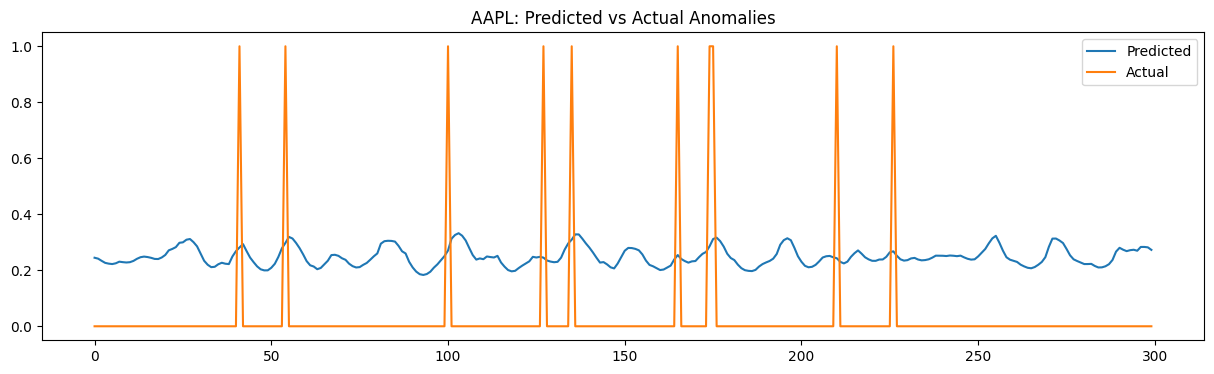


Evaluating model for VOO
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      4709
           1       0.09      0.28      0.13       261

    accuracy                           0.80      4970
   macro avg       0.52      0.56      0.51      4970
weighted avg       0.91      0.80      0.85      4970



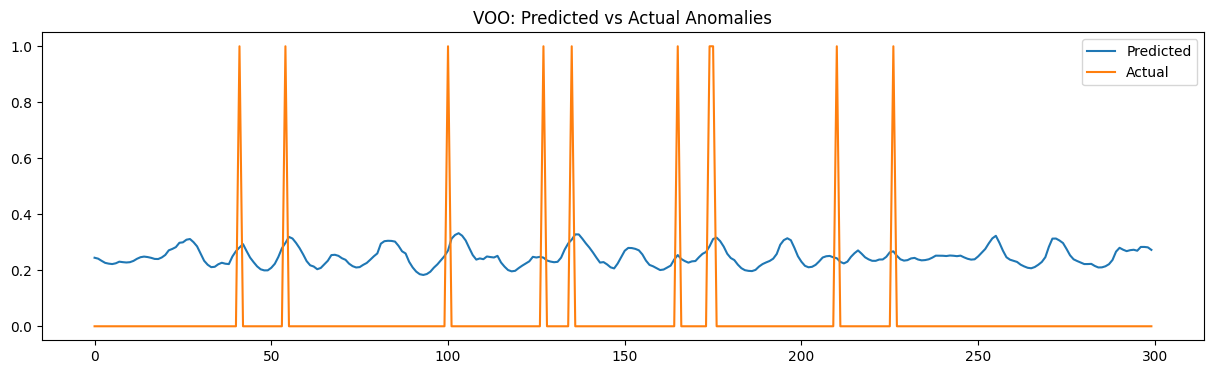


Evaluating model for DIA
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      4709
           1       0.09      0.28      0.13       261

    accuracy                           0.80      4970
   macro avg       0.52      0.56      0.51      4970
weighted avg       0.91      0.80      0.85      4970



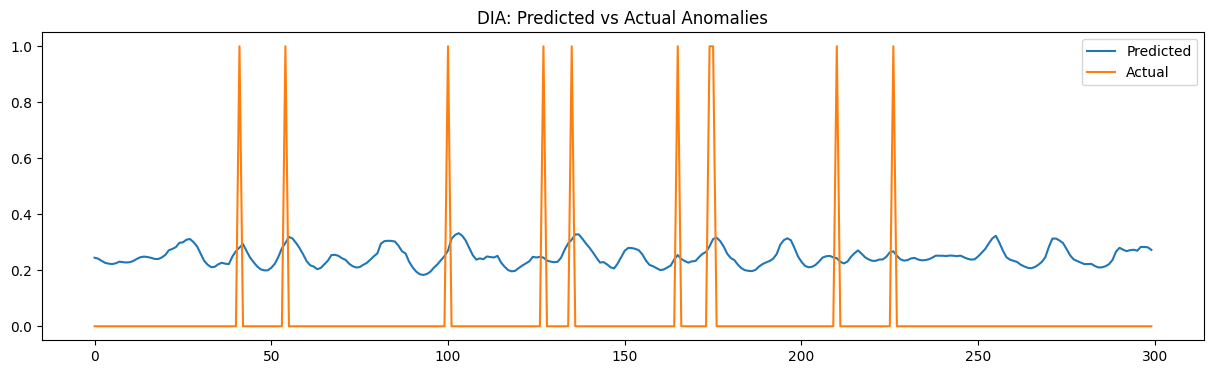

In [ ]:
## YENI VERSIYON

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

for symbol in symbols:
    print(f"\nEvaluating model for {symbol}")

    df = data_dict[symbol]

    # Skip if sequences not available
    if 'X_seq' not in locals():
        print(f"{symbol}: No sequences found. Skipping.")
        continue

    y_pred = model.predict(X_seq)
    y_pred_labels = (y_pred > 0.3).astype(int)

    print(classification_report(y_seq, y_pred_labels))

    # Optional: Visualize predictions
    plt.figure(figsize=(15, 4))
    plt.plot(y_pred[:300], label='Predicted')
    plt.plot(y_seq[:300], label='Actual')
    plt.legend()
    plt.title(f"{symbol}: Predicted vs Actual Anomalies")
    plt.show()


B A C K  E N D  T E S T I N G

In [ ]:
import numpy as np

initial_cash = 10000

for symbol in symbols:
    df = data_dict[symbol].copy()


    if 'Portfolio' not in df.columns:
        print(f"{symbol}: No portfolio values found. Skipping.")
        continue

    portfolio_values = df['Portfolio'].values

    final_value = portfolio_values[-1]
    profit_pct = ((final_value - initial_cash) / initial_cash) * 100

    # Max drawdown calculation
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (portfolio_values - peak) / peak
    max_drawdown_pct = drawdown.min() * 100

    print(f"\n=== {symbol} Backtest Summary ===")
    print(f"Total Profit: {profit_pct:.2f}%")
    print(f"Maximum Drawdown: {max_drawdown_pct:.2f}%")



=== AAPL Backtest Summary ===
Total Profit: 23.07%
Maximum Drawdown: -16.02%

=== VOO Backtest Summary ===
Total Profit: 33.44%
Maximum Drawdown: -5.94%

=== DIA Backtest Summary ===
Total Profit: 28.75%
Maximum Drawdown: -5.98%


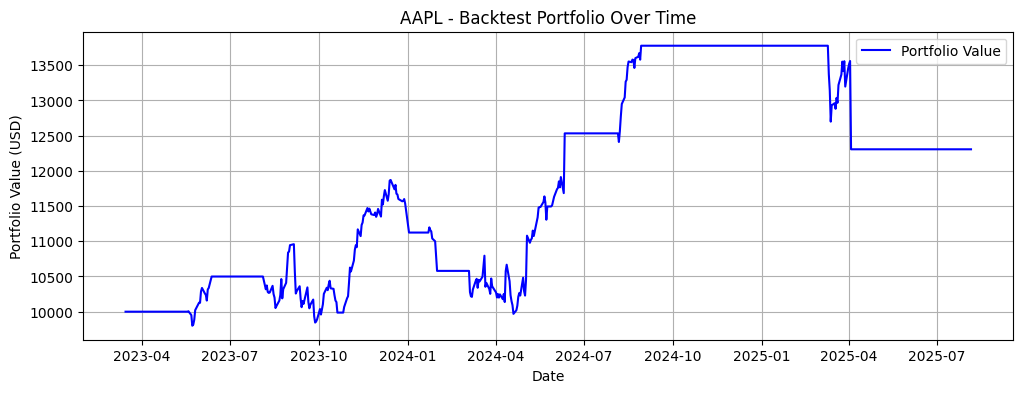

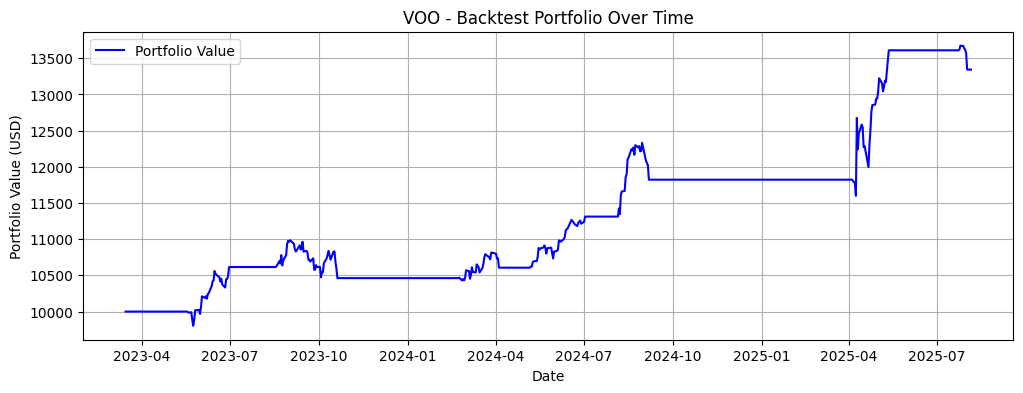

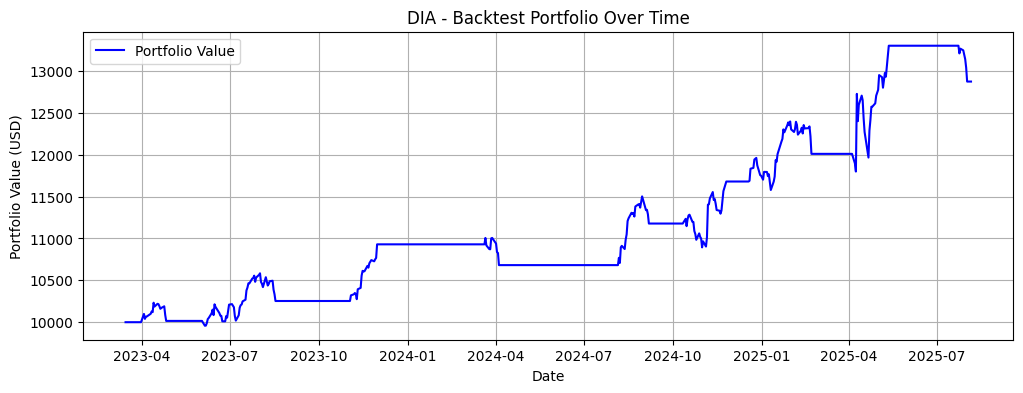

In [ ]:
import matplotlib.pyplot as plt

for symbol in symbols:
    df = data_dict[symbol]

    if 'Portfolio' not in df.columns:
        print(f"{symbol}: No backtest results found. Skipping.")
        continue

    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df['Portfolio'], label='Portfolio Value', color='blue')
    plt.title(f"{symbol} - Backtest Portfolio Over Time")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (USD)")
    plt.legend()
    plt.grid()
    plt.show()
